# Numerical Solutions to Partial Differential Equations
Main source: https://github.com/barbagroup/CFDPython
$ \newcommand{\pdiff}[2]{\frac{\partial #1}{\partial #2}} $

$ \newcommand{\ftdiff}[2]{\frac{#1_i^{n+1} - #1_i^{n}}{\Delta #2}} $

$ \newcommand{\fxdiff}[2]{\frac{#1_{i+1}^n - #1_i^n}{\Delta #2}} $
$ \newcommand{\bxdiff}[2]{\frac{#1_i^n - #1_{i-1}^n}{\Delta #2}} $

$ \newcommand{\ctdiff}[2]{\frac{#1_i^{n+1} - #1_i^{n-1}}{2\Delta #2}}$
$ \newcommand{\cxdiff}[2]{\frac{#1_{i+1}^n - #1_{i-1}^n}{2\Delta #2}}$

## 1D Linear Convection

The 1D linear convection equation is as follows


$$ \pdiff{u}{t} + c\pdiff{u}{x} = 0 $$

where $u$ is a function of $x$ and $t$ while $c$ is the wave speed of $u$. It can be proven that if the initial condition is $u(x, 0) = u_0(x)$, then the exact solution is $u(x, t) = u_0(x - ct)$.

### Discretization

We can construct a grid wherein each cell, denoted by $u_i^n$, corresponds to $u(x_i, t_n)$ where $x_i$ and $t_n$ are the $x$ and $t$ values at that cell. Initially, we only know the values $u_i^0 = u(x_i, 0)$. Fortunately, these are enough to approximate the values of $u$ at future timesteps $t_n$.

### Forward Difference Scheme

Recall that

$$\pdiff{u}{t} = \displaystyle{\lim_{\Delta t \to 0}}  \frac{u(x, t +\Delta t) - u(x, t)}{\Delta t}$$

If we let $u_i^n = u(x, t)$, $u_i^{n+1} = u(x, t + \Delta t)$, and $\Delta t$ be a "small enough" change in time, then we can approximate $ \pdiff{u}{t} $ with

$$ \pdiff{u}{t} \approx \ftdiff{u}{t}$$

### Backward Difference Scheme

Again, recall that

$$\pdiff{u}{x} =\displaystyle{\lim_{\Delta x \to 0}}  \frac{u(x + \Delta x, t) - u(x, t)}{\Delta x} = \displaystyle{\lim_{\Delta x \to 0}}  \frac{u(x, t) - u(x - \Delta x, t)}{\Delta x}$$

We can approximate $\pdiff{u}{x}$ using the formula in the middle and the forward difference scheme as discussed above. However, to make computations simpler, we can also use the rightmost formula and the backward difference scheme.

$$ \pdiff{u}{x} \approx \bxdiff{u}{x} $$

### Upwind Scheme

Since, we already know how to approximate the partial derivatives over $x$ and $t$, we can use them to construct an approximation of the 1D linear convection equation as follows

$$ \ftdiff{u}{t} + c\bxdiff{u}{x} = 0$$

We can solve for $x_i^{n+1}$ to get

$$u_i^{n+1} = u_i^n - c\frac{\Delta t}{\Delta x}(u_i^{n} - u_{i-1}^{n})$$

This formula basically describes how the value of $u$ at point $x_i$ changes after $\Delta t$

#### Implementation of the Upwind Scheme

First, let's import the necessary libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

The upwind solver is relatively easy to implement.

In [ ]:
def upwind_solver(u_0, dt, dx, c, nx, num_timesteps,
                  boundary_condition="fixed", boundary_fixed_value=0):
  def move_up(u, i):
    return u[i] - c*dt/dx*(u[i] - u[i-1])
    
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
    elif boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
    else:
      u_next[0] = 0
    
    u_now = u_next.copy()
  return u_next

### Central Difference Scheme

As mentioned earlier, we can use either the forward or the backward difference scheme to approximate the partial derivatives. We can, of course, use the average of the two schemes.

$$ \pdiff{u}{x} \approx \frac{\fxdiff{u}{x} + \bxdiff{u}{x}}{2}$$
$$ \pdiff{u}{x} \approx \cxdiff{u}{x}$$

Thus, our update formula would then be

$$u_i^{n+1} = u_i^n - c\frac{\Delta t}{2\Delta x}(u_{i+1}^{n} - u_{i-1}^{n})$$

#### Implementation of the Central Difference Scheme

In [ ]:
def central_difference_solver(u_0, dt, dx, c, nx, num_timesteps,
                                       boundary_condition="fixed",
                                       boundary_fixed_value = 0):  
  def move_up(u, i):
    return u[i] - ((c*dt)/(2*dx))*(u[i+1] - u[i-1])
    
  u_prev = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_prev, i)
      
    if boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
      u_next[-1] = boundary_fixed_value
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_prev, 0)
      u_next[-1] = move_up(u_prev, -1)
    
    u_prev = u_next.copy()
  return u_next

### Beam-Warming Scheme

Notice how unstable the central difference scheme is, even with a periodic boundary condition. To solve this problem, we can use the central difference scheme not only on $x$ but also on $t$.

$$ \ctdiff{u}{t} + c\cxdiff{u}{x} = 0$$

Thus, our update formula becomes

$$u_i^{n+1} = u_i^{n-1} - c\frac{\Delta t}{\Delta x}(u_{i+1}^{n} - u_{i-1}^{n})$$

Notice that $u_i^{n+1}$ does not depend on $u_i^n$ anymore but on $u_i^{n-1}$ instead.

#### Implementation of the Beam-Warming Scheme

In [ ]:
def beam_warming_solver(u_0, dt, dx, c, nx, num_timesteps,
                                       boundary_condition="fixed",
                                       boundary_fixed_value = 0):
  def move_up(u, u_prev, i):
    return u_prev[i] - ((c*dt)/dx)*(u[i+1] - u[i-1])
    
  u_prev = u_0.copy()
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_now, u_prev, i)
      
    if boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
      u_next[-1] = boundary_fixed_value
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_now, u_prev, 0)
      u_next[-1] = move_up(u_now, u_prev, -1)
    
    u_prev = u_now.copy()
    u_now = u_next.copy()
  return u_next

### Tests

First, we have to initialize some constants and the initial value of $u$. Let the domain of our grid be $x \in [-\pi, \pi], t \in [0, 1]$

In [ ]:
nx = 100
left_x = -np.pi
right_x = np.pi
dx = (right_x - left_x) / (nx-1)

nt = 50
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

c = 1

#### $u_0(x) = sin(x)$

And let the initial value of $u$ be $u_0(x) = sin(x)$. With this, the exact solution must be $u(x, t) = sin(x - ct)$

In [ ]:
def u_init(x):
  return np.sin(x)

def u_solution(x, t, c):
  return np.sin(x - c*t);

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

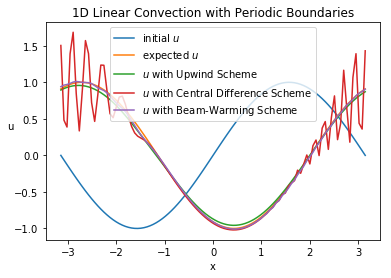

In [ ]:
u_exact = u_solution(x, left_t + dt*100, c)
u_upwind = upwind_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_central = central_difference_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = beam_warming_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_exact, label="expected $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_central, label="$u$ with Central Difference Scheme")
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme")

plt.legend(loc='upper center')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.title("1D Linear Convection with Periodic Boundaries")
plt.show()

#### $u_0$ that looks like a hat

In [ ]:
def u_init(x):
  u = np.zeros(x.shape)
  u[u_0.shape[0]//4 : u_0.shape[0]//2] = 1
  return u

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

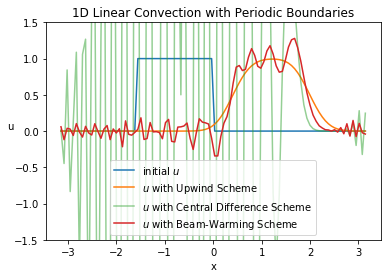

In [ ]:
u_upwind = upwind_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_central = central_difference_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = beam_warming_solver(u_0, dt, dx, c, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_central, label="$u$ with Central Difference Scheme", alpha=0.5)
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme")

plt.legend(loc='lower center')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.ylim(-1.5, 1.5)
plt.title("1D Linear Convection with Periodic Boundaries")
plt.show()

## 1D Nonlinear Convection

The methods above can easily be generalized to systems the form

$$ \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0 $$

If $f(u) = cu$, then we end up with a linear system as discussed above.

### Generalized Upwind Scheme

Interestingly, we don't actually need to do more maths and just discretize the equation directly as shown below:

$$ \ftdiff{u}{t} + \frac{f(u_i^n) - f(u_{i-1}^n)}{\Delta x} = 0$$
$$u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}(f(u_i^{n}) - f(u_{i-1}^{n}))$$

#### Implementation of the Generalilzed Upwind Scheme

In [ ]:
def general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps,
                  boundary_condition="fixed", boundary_fixed_value=0):
  def move_up(u, i):
    return u[i] - dt/dx*(f(u[i]) - f(u[i-1]))
    
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
    elif boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
    else:
      u_next[0] = 0
    
    u_now = u_next.copy()
  return u_next

### Generalized Beam-Warming Scheme

Interestingly, we don't actually need to do more maths and just discretize the equation directly as shown below:

$$ \ctdiff{u}{t} + \frac{f(u_{i+1}^n) - f(u_{i-1}^n)}{2\Delta x} = 0$$
$$u_i^{n+1} = u_{i-1}^n - \frac{\Delta t}{\Delta x}(f(u_{i+1}^{n}) - f(u_{i-1}^{n}))$$

#### Implementation of the Generalized Beam-Warming Scheme

In [ ]:
def general_beam_warming_solver(u_0, dt, dx, c, nx, num_timesteps,
                                       boundary_condition="fixed",
                                       boundary_fixed_value = 0):
  def move_up(u, u_prev, i):
    return u_prev[i] - (dt/dx)*(f(u[i+1]) - f(u[i-1]))
    
  u_prev = u_0.copy()
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_now, u_prev, i)
      
    if boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
      u_next[-1] = boundary_fixed_value
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_now, u_prev, 0)
      u_next[-1] = move_up(u_now, u_prev, -1)
    
    u_prev = u_now.copy()
    u_now = u_next.copy()
  return u_next

### Nonstaggered Lax-Friedrich Scheme

The Lax-Friedrich scheme takes a slightly different approach.

First, it approximates the midpoint cells: 

$$\frac{u_{i+\frac{1}{2}}^{n+1} - u_{i+\frac{1}{2}}^n}{\Delta t} + \frac{f(u_{i+1}^n) - f(u_{i}^n)}{\Delta x} = 0$$

Where:

$$ u_{i+\frac{1}{2}}^n \approx \frac{u_{i+1}^n + u_{i}^n}{2} $$

Thus, we have

$$u_{i+\frac{1}{2}}^{n+1} = \frac{1}{2}(u_{i+1}^n + u_{i}^n) - \frac{\Delta t}{\Delta x}(f(u_{i+1}^n) - f(u_{i}^n))$$ 

It then uses these half-cells for the next step:

$$u_{i}^{n+2} = \frac{1}{2}(u_{i-\frac{1}{2}}^n + u_{i+\frac{1}{2}}^n) - \frac{\Delta t}{\Delta x}(f(u_{i+\frac{1}{2}}^n) - f(u_{i-\frac{1}{2}}^n))$$ 

And so on. Note that this method requires the use of a staggered grid which is much of a hassle to implement. To fix remove this stagerring, we can let $u_i^{n+1}$ be the average of its neighboring half-cells and forget about the second step in the original algorithm.

$$ u_i^{n+1} := \frac{u_{i-\frac{1}{2}}^{n+1} + u_{i+\frac{1}{2}}^{n+1}}{2} $$

$$u_{i}^{n+1} = \frac{1}{4}(u_{i-1}^n + 2u_{i}^n + u_{i+1}^n) - \frac{\Delta t}{2\Delta x}(f(u_{i+1}^n) - f(u_{i-1}^n))$$ 

#### Implementation of the Nonstaggered Lax-Friedrich Scheme

In [ ]:
def lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps,
                         boundary_condition="fixed", boundary_fixed_value = 0):  
  def _next(j):
    return j+1 if j+1 < nx else 1
  
  def _prev(j):
    return j-1 if j-1 >= 0 else nx-2
  
  def move_up(u, i):
    return (1/4)*(u[_prev(i)] + 2*u[i] + u[_next(i)]) - \
           (dt/(2*dx))*(f(u[_next(i)]) - f(u[_prev(i)]))
    
  u_now  = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "fixed":
      u_next[0] = boundary_fixed_value
      u_next[-1] = boundary_fixed_value
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
      u_next[-1] = move_up(u_now, -1)
    
    u_now = u_next.copy()
  return u_next

### Tests

In [ ]:
nx = 100
left_x = -np.pi
right_x = np.pi
dx = (right_x - left_x) / (nx-1)

nt = 50
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

c = 1

#### $f(u) = u$ and $u_0(x) = sin(x)$

In [ ]:
def f(u):
  return u

def u_init(x):
  return np.sin(x)

def u_solution(x, t, c):
  return np.sin(x - c*t);

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

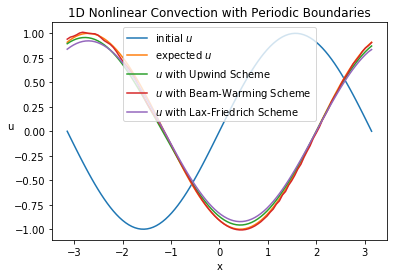

In [ ]:
u_exact = u_solution(x, left_t + dt*100, c)
u_upwind = general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = general_beam_warming_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_lxf = lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_exact, label="expected $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme")
plt.plot(x, u_lxf, label="$u$ with Lax-Friedrich Scheme")

plt.legend(loc='upper center')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.title("1D Nonlinear Convection with Periodic Boundaries")
plt.show()

#### $f(u) = \frac{u^2}{2}$ and $u_0(x) = 0.25 + 0.5sin(\pi x)$

In [ ]:
nx = 100
left_x = -1
right_x = 1
dx = (right_x - left_x) / (nx-1)

nt = 50
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

c = 1

In [ ]:
def f(u):
  return (u**2)/2

def u_init(x):
  return 0.25 + 0.5*np.sin(np.pi * x)

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


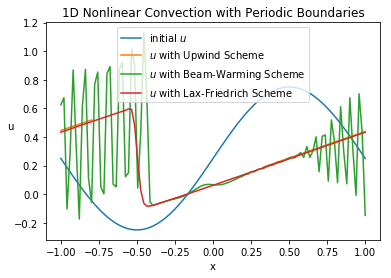

In [ ]:
u_upwind = general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = general_beam_warming_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_lxf = lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme")
plt.plot(x, u_lxf, label="$u$ with Lax-Friedrich Scheme")

plt.legend(loc='upper center')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.title("1D Nonlinear Convection with Periodic Boundaries")
plt.show()

#### $f(u) = u$ and $u_0(x)$ that looks like a hat

In [ ]:
nx = 100
left_x = -1
right_x = 1
dx = (right_x - left_x) / (nx-1)

nt = 100
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

c = 1

In [ ]:
def f(u):
  return u

def u_init(x):
  u = np.zeros(x.shape)
  u[(x >= -0.5) & (x <= 0)] = 1
  return u

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

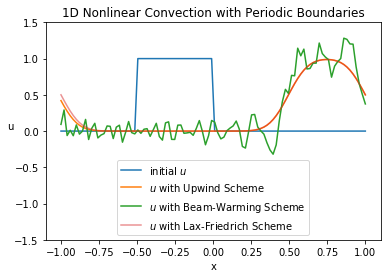

In [ ]:
u_upwind = general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = general_beam_warming_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_lxf = lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme")
plt.plot(x, u_lxf, label="$u$ with Lax-Friedrich Scheme")

plt.legend(loc='lower center')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.ylim(-1.5, 1.5)
plt.title("1D Nonlinear Convection with Periodic Boundaries")
plt.show()

#### $f(u) = \left(\frac{u^2}{4u^2 + (1-u)^2}\right)$ and $u_0(x)$ that looks like a hat

In [ ]:
nx = 100
left_x = -1
right_x = 1
dx = (right_x - left_x) / (nx-1)

nt = 50
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

c = 1

In [ ]:
def f(u):
  return (u**2)/(4*u**2 + (1-u)**2)

def u_init(x):
  u = np.zeros(x.shape)
  u[(x >= -0.5) & (x <= 0)] = 1
  return u

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

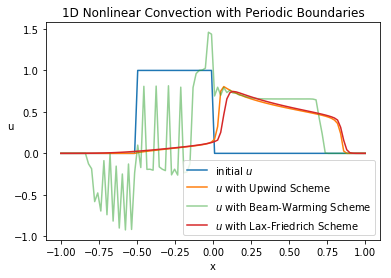

In [ ]:
u_upwind = general_upwind_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_beam = general_beam_warming_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")
u_lxf = lax_friedrich_solver(u_0, dt, dx, f, nx, num_timesteps=100,
                         boundary_condition="periodic")

plt.plot(x, u_0, label="initial $u$")
plt.plot(x, u_upwind, label="$u$ with Upwind Scheme")
plt.plot(x, u_beam, label="$u$ with Beam-Warming Scheme", alpha=0.5)
plt.plot(x, u_lxf, label="$u$ with Lax-Friedrich Scheme")

plt.legend(loc='lower right')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.title("1D Nonlinear Convection with Periodic Boundaries")
plt.show()

## 1D Linear Diffusion
$$ \pdiff{u}{t} = v\pdiff{^2u}{x^2} $$

We already know that $ \pdiff{u}{x}  \approx \frac{u(x+\Delta x) - u(x)}{\Delta x} \approx \frac{u(x) - u(x - \Delta x)}{\Delta x}$. We can compose the two schemes to approximate $ \pdiff{^2u}{x^2} $

$$\frac{\partial^2 u}{\partial x^2}
\approx \frac{\frac{u(x+\Delta x) - u(x)}{\Delta x} - \frac{u((x+\Delta x) - \Delta x) - u(x - \Delta x)}{\Delta x}}{\Delta x}
\approx \frac{\frac{u(x+\Delta x) - u((x - \Delta x) + \Delta x)}{\Delta x} - \frac{u(x) - u(x - \Delta x)}{\Delta x}}{\Delta x}$$

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u(x + \Delta x) - 2u(x) + u(x - \Delta x)}{\Delta x^2}$$

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Thus, the diffusion equation becomes
$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = v\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$
$$u_i^{n+1} = u_i^n + \frac{v\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$



#### Implementation of the 1D Linear Diffusion Solver

In [ ]:
def diffusion_solver(u_0, dt, dx, v, nx, num_timesteps,
                     boundary_condition="fixed",
                     boundary_fixed_values = 0):
  def move_up(u, i):
    return u[i] + v*(dt/(dx**2))*(u[i+1] - 2*u[i] + u[i-1])
    
  u_now = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      u_next[i] = move_up(u_now, i)
      
    if boundary_condition == "fixed":
      u_next[0] = u_next[-1] = boundary_fixed_values
    elif boundary_condition == "periodic":
      u_next[0] = move_up(u_now, 0)
      u_next[-1] = move_up(u_now, -1)
    elif boundary_condition == "dirichlet":
      u_next[0] = boundary_fixed_values[0]
      u_next[-1] = boundary_fixed_values[1]
    elif boundary_condition == "neumann":
      u_next[-1] = u_next[-2]
    
    u_now = u_next.copy()
  return u_next

### Tests

In [ ]:
nx = 100
left_x = 0
right_x = 1
dx = (right_x - left_x) / (nx-1)

nt = 100
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

v = 1.22e-3

In [ ]:
def u_init(x):
  u = np.zeros(x.shape)
  u[0] = 100
  return u

In [ ]:
x = np.linspace(left_x, right_x, nx)
u_0 = u_init(x)

#### Heat Conduction with the Dirichlet Boundary

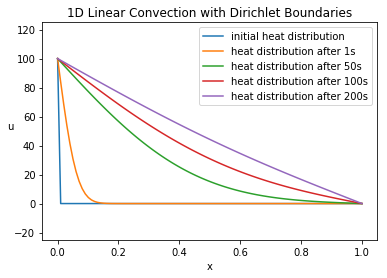

In [ ]:
u_diffusion_1s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=nt,
                                  boundary_condition="dirichlet",
                                  boundary_fixed_values=[100, 0])
u_diffusion_50s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=50*nt,
                                   boundary_condition="dirichlet",
                                   boundary_fixed_values=[100, 0])
u_diffusion_100s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=100*nt,
                                    boundary_condition="dirichlet",
                                    boundary_fixed_values=[100, 0])
u_diffusion_200s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=200*nt,
                                    boundary_condition="dirichlet",
                                    boundary_fixed_values=[100, 0])

plt.plot(x, u_0, label="initial heat distribution")
plt.plot(x, u_diffusion_1s, label="heat distribution after 1s")
plt.plot(x, u_diffusion_50s, label="heat distribution after 50s")
plt.plot(x, u_diffusion_100s, label="heat distribution after 100s")
plt.plot(x, u_diffusion_200s, label="heat distribution after 200s")

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.ylim(-25, 125)
plt.title("1D Linear Convection with Dirichlet Boundaries")
plt.show()

#### Heat Conduction with the Neumann Boundary

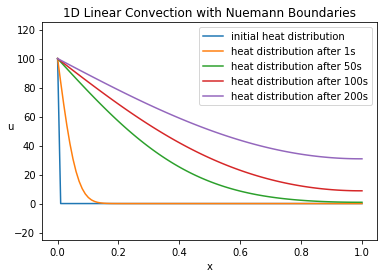

In [ ]:
u_diffusion_1s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=nt,
                                  boundary_condition="neumann")
u_diffusion_50s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=50*nt,
                                  boundary_condition="neumann")
u_diffusion_100s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=100*nt,
                                  boundary_condition="neumann")
u_diffusion_200s = diffusion_solver(u_0, dt, dx, v, nx, num_timesteps=200*nt,
                                  boundary_condition="neumann")

plt.plot(x, u_0, label="initial heat distribution")
plt.plot(x, u_diffusion_1s, label="heat distribution after 1s")
plt.plot(x, u_diffusion_50s, label="heat distribution after 50s")
plt.plot(x, u_diffusion_100s, label="heat distribution after 100s")
plt.plot(x, u_diffusion_200s, label="heat distribution after 200s")

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("u", rotation=0)
plt.ylim(-25, 125)
plt.title("1D Linear Convection with Nuemann Boundaries")
plt.show()

## 2D Convection
$$ \pdiff{u}{t} + \nabla u = 0 $$
$$ \pdiff{u}{t} + \pdiff{u}{x} + \pdiff{u}{y} = 0 $$

### Upwind Scheme

Just as the 1D case, we can use upward difference scheme for the time dimension and backward difference scheme for the space dimensions. Thus, we can discretize the solution above as:

$$ \ftdiff{u}{t} + \bxdiff{u}{x} + \bxdiff{u}{y} = 0 $$

$$ u_{i,j}^{n+1} = u_{i,j}^n - \frac{\Delta t}{\Delta x}(u_{i, j}^n - u_{i-1, j}^n) - \frac{\Delta t}{\Delta x}(u_{i, j}^n - u_{i, j-1}^n)  $$

This can also easily be extended to the nonlinear case

$$ \pdiff{u}{t} + \pdiff{f(u)}{x} + \pdiff{f(u)}{y} = 0 $$

$$ u_{i,j}^{n+1} = u_{i,j}^n - \frac{\Delta t}{\Delta x}(f(u_{i, j}^n) - f(u_{i-1, j}^n)) - \frac{\Delta t}{\Delta x}(f(u_{i, j}^n) - f(u_{i, j-1}^n))  $$

#### Implementation of the Upwind Scheme for the 2D Convection Equation

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [ ]:
def convection_2d_solve(u_0, dt, dx, dy, f, nx, ny, num_timesteps,
                        boundary_condition="fixed",
                        boundary_fixed_values = [0,0]):
  def move_up(u, i, j):
    return u[i][j] \
           - (dt/dx)*(f(u[i][j]) - f(u[i-1][j])) \
           - (dt/dy)*(f(u[i][j]) - f(u[i][j-1]))
    
  u_prev = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx):
      for j in range(1, ny):
        u_next[i][j] = move_up(u_prev, i, j)
        
        if boundary_condition == "fixed":
          u_next[0,:], u_next[:,0] = boundary_fixed_values
        elif boundary_condition == "periodic":
          u_next[0,:] = u_next[-1,:]
          u_next[:,0] = u_next[:,-1]
    u_prev = u_next.copy()
  return u_next

### Tests

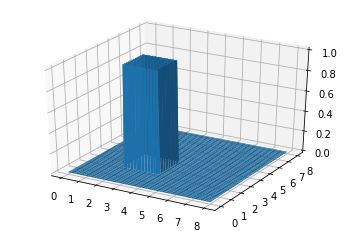

In [ ]:
nx = 100
left_x = 0
right_x = 8
dx = (right_x - left_x) / nx

ny = 100
left_y = 0
right_y = 8
dy = (right_y - left_y) / ny

nt = 101
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

def f(u):
  return (u**2)/2

def u_init(x, y):
  u = np.zeros((nx, ny))
  u[nx//4:nx//2, ny//4:ny//2] = 1
  return u

x = np.linspace(left_x, right_x, nx)
y = np.linspace(left_y, right_y, ny)
u_0 = u_init(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u_0)

In [ ]:
u_end_1s = convection_2d_solve(u_0, dt, dx, dy, f, nx, ny, nt,
                            boundary_condition="fixed",
                            boundary_fixed_values=(0,0))
u_end_5s = convection_2d_solve(u_0, dt, dx, dy, f, nx, ny, 5*nt,
                            boundary_condition="fixed",
                            boundary_fixed_values=(0,0))

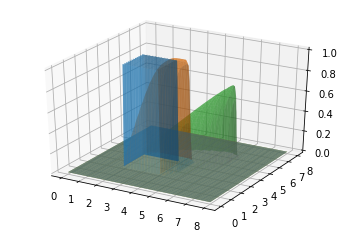

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u_0, alpha=0.5)     
surf = ax.plot_surface(X, Y, u_end_1s, alpha=0.5)                 
surf = ax.plot_surface(X, Y, u_end_5s, alpha=0.5)
plt.show()

## 2D Diffusion

$$ \pdiff{u}{t} = v\pdiff{^2u}{x^2} + v\pdiff{^2 u}{y^2} $$

Discretizing gives us
$$ \frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = v\frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2}+ v\frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}$$
$$u_{i,j}^{n+1} = u_{i,j}^n + \frac{v\Delta t}{\Delta x^2}(u_{i+1,j}^n - 2u_{i,j}^n- u_{i-1,j}^n) + \frac{v\Delta t}{\Delta y^2}(u_{i,j+1}^n - 2u_{i,j}^n- u_{i,j-1}^n)$$

Again, this can easily be extended to the nonlinear case
$$ \frac{\partial u}{\partial t} = v\frac{\partial^2 f(u)}{\partial x^2} + v\frac{\partial^2 f(u)}{\partial y^2}$$
$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = v\frac{f(u_{i+1,j}^n) - 2f(u_{i,j}^n)- f(u_{i-1,j}^n)}{\Delta x^2}+ v\frac{f(u_{i,j+1}^n) - 2f(u_{i,j}^n)- f(u_{i,j-1}^n)}{\Delta y^2}$$
$$u_{i,j}^{n+1} = u_{i,j}^n + \frac{v\Delta t}{\Delta x^2}(f(u_{i+1,j}^n) - 2f(u_{i,j}^n) + f(u_{i-1,j}^n)) + \frac{v\Delta t}{\Delta y^2}(f(u_{i,j+1}^n) - 2f(u_{i,j}^n) + f(u_{i,j-1}^n))$$

In [ ]:
def diffusion_2d_solve(u_0, dt, dx, dy, v, f, nx, ny, num_timesteps,
                        boundary_condition="fixed",
                        boundary_fixed_values = [0, 0, 0, 0]):
  def move_up(u, i, j):
    return u[i][j] \
           + (v*dt/(dx**2))*(f(u[i+1][j]) - 2*f(u[i][j]) + f(u[i-1][j])) \
           + (v*dt/(dy**2))*(f(u[i][j+1]) - 2*f(u[i][j]) + f(u[i][j-1]))
    
  u_prev = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      for j in range(1, ny-1):
        u_next[i][j] = move_up(u_prev, i, j)
    
    if boundary_condition == "fixed":
      u_next[0,:] = u_next[-1:] = u_next[:,0] = u_next[:,-1] = boundary_fixed_values
    elif boundary_condition == "periodic":
      u_next[0,:]  = u_next[-2,:]
      u_next[-1,:] = u_next[1,:]
      u_next[:,0]  = u_next[:,-2]
      u_next[:,-1] = u_next[:,1]
    u_prev = u_next.copy()
  return u_next

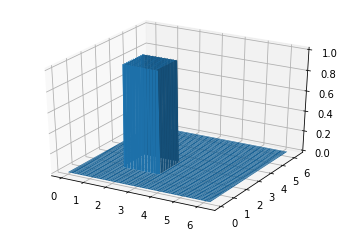

In [ ]:
nx = 100
left_x = 0
right_x = 8
dx = (right_x - left_x) / nx

ny = 100
left_y = 0
right_y = 8
dy = (right_y - left_y) / ny

nt = 101
left_t = 0
right_t = 1
dt = (right_t - left_t) / nt

v = 0.05

def f(u):
  return u

def u_init(x, y):
  u = np.zeros((nx, ny))
  u[nx//4:nx//2, ny//4:ny//2] = 1
  return u

x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
u_0 = u_init(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u_0)

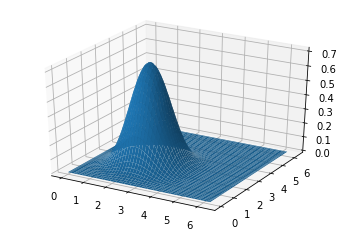

In [ ]:
u_end = diffusion_2d_solve(u_0, dt, dx, dy, v, f, nx, ny, 5*nt,
                           boundary_condition="fixed",
                           boundary_fixed_values=0)

fig = plt.figure()
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u_end)

## 2D Laplace Equation

$$ \pdiff{^2 p}{x^2} + \pdiff{^2 p}{y^2} = 0$$

Discretizing gives us
$$ \frac{p_{i+1,j}^n - 2p_{i,j}^n - p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n - p_{i,j-1}^n}{\Delta y^2} = 0 $$
$$ p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n + p_{i-1,j}^n) + \Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)} $$

Note that the Laplace Equation doesn't have a time dependence. Thus, we're not really calculating the value of $p$ at time $t$ but the equilibrium state of the system.

In [ ]:
def plot2D(x, y, p):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

In [ ]:
def laplace_2d_solve(u_0, dx, dy, l1norm_target, b_value):
  def move_up(u, i, j):
    return ((dy**2)*(u[i+1][j] + u[i-1][j]) + (dx**2)*(u[i][j+1] + u[i][j-1])) / \
           (2*(dx**2 + dy**2))
  
  l1norm = 1
  u_prev = u_0.copy()
  u_next = u_0.copy()
  while l1norm > l1norm_target:
    for i in range(1, nx-1):
      for j in range(1, ny-1):
        u_next[i][j] = move_up(u_prev, i, j)
    u_next[0,:] = 0
    u_next[-1,:] = b_value
    u_next[:,0] = u_next[:,1]
    u_next[:,-1] = u_next[:,-2]
    
    l1norm = (np.abs(u_next).sum() - np.abs(u_prev).sum()) / np.abs(u_prev).sum()
    u_prev = u_next.copy()
  return u_next

In [ ]:
nx = 31
lx = 2*np.pi
dx = lx / (nx-1)

ny = 31
ly = 2*np.pi
dy = ly / (ny-1)

x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
b_value = y

u_0 = np.zeros((nx, ny))
u_0[0,:] = 0
u_0[-1,:] = b_value
u_0[:,0] = u_0[:,1]
u_0[:,-1] = u_0[:,-2]

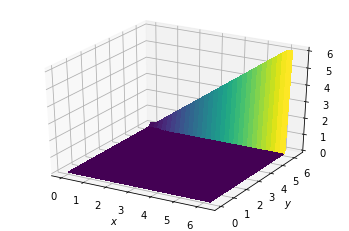

In [ ]:
plot2D(x, y, u_0)

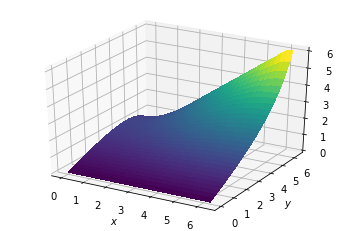

In [ ]:
u_end = laplace_2d_solve(u_0, dx, dy, 1e-4, b_value)
plot2D(x, y, u_end)

## 2D Poisson Equation
The 2D Poisson Equation is similar to the Laplace Equation except that a finite value affects the field.

$$ \pdiff{^2 p}{x^2} + \pdiff{^2 p}{y^2} = s $$

Discretizing gives us

$$ \frac{p_{i+1,j}^n - 2p_{i,j}^n - p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n - p_{i,j-1}^n}{\Delta y^2} = s_{i,j}^n $$

$$ p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n + p_{i-1,j}^n) + \Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n) - s_{i,j}^n  \Delta x^2 \Delta y^2}{2(\Delta x^2 + \Delta y^2)} $$

In [ ]:
def poisson_2d_solve(u_0, dx, dy, s, num_timesteps):
  def move_up(u, i, j):
    return ((dy**2) * (u[i+1][j] + u[i-1][j]) +
            (dx**2) * (u[i][j+1] + u[i][j-1]) -
            s[i][j] * dx**2 * dy**2) / \
           (2*(dx**2 + dy**2))
  
  u_prev = u_0.copy()
  u_next = u_0.copy()
  for _ in range(num_timesteps):
    for i in range(1, nx-1):
      for j in range(1, ny-1):
        u_next[i][j] = move_up(u_prev, i, j)
    # boundery conditions
    u_next[0,:] = 0
    u_next[-1,:] = 0
    u_next[:,0] = 0
    u_next[:,-1] = 0
    
    u_prev = u_next.copy()
  return u_next

In [ ]:
nx = 31
lx = 2*np.pi
dx = lx / (nx-1)

ny = 31
ly = 2*np.pi
dy = ly / (ny-1)

nt = 101
lt = 1
dt = lt / nt

x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
b_value = y

u_0 = np.zeros((nx, ny))

s = np.zeros((nx, ny))
s[nx//4, ny//4] = 100
s[3*nx//4, 3*ny//4] = -100

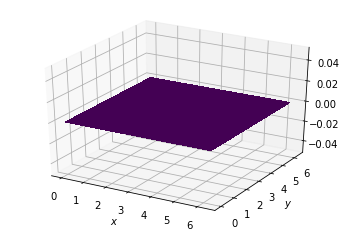

In [ ]:
plot2D(x, y, u_0)

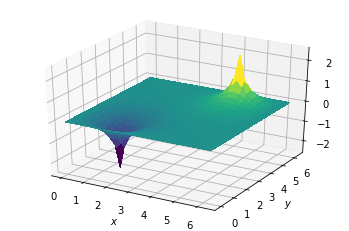

In [ ]:
u_end = poisson_2d_solve(u_0, dx, dy, s, nt)
plot2D(x, y, u_end)